In [4]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import yaml
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

In [5]:
train_tp = pd.read_csv('../input/rfcx-species-audio-detection/train_tp.csv')
train_fp = pd.read_csv('../input/rfcx-species-audio-detection/train_fp.csv')
tmp = pd.DataFrame(train_tp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_tp = pd.merge(train_tp, tmp, on="recording_id", how='inner')
train_tp["count"].value_counts()

1    1065
2     110
3      24
4      12
5       5
Name: count, dtype: int64

In [6]:
tmp = pd.DataFrame(train_fp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_fp = pd.merge(train_fp, tmp, on="recording_id", how='inner')
train_fp["count"].value_counts()

1     2028
2     1716
3     1635
4     1356
5      575
6      294
7      126
8       32
10      10
9        9
Name: count, dtype: int64

In [7]:
train_path_list = os.listdir("../input/rfcx-species-audio-detection/train")
test_path_list = os.listdir("../input/rfcx-species-audio-detection/test")
print(f"train:{len(train_path_list)}, test:{len(test_path_list)}")
# print("train")
# for path in tqdm(train_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/train", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)
# print("test")
# for path in tqdm(test_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/test", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)

train:4727, test:1992


In [8]:
tp_list = train_tp["recording_id"].unique() + ".flac"
train_tp_list = []
for path in train_path_list:
    if path in tp_list:
        train_tp_list.append(os.path.join("../input/rfcx-species-audio-detection/train", path))

In [9]:
def logmelfilterbank(
    audio,
    sampling_rate,
    fft_size=1024,
    hop_size=256,
    win_length=None,
    window="hann",
    num_mels=80,
    fmin=None,
    fmax=None,
    eps=1e-10,
):
    """Compute log-Mel filterbank feature.

    Args:
        audio (ndarray): Audio signal (T,).
        sampling_rate (int): Sampling rate.
        fft_size (int): FFT size.
        hop_size (int): Hop size.
        win_length (int): Window length. If set to None, it will be the same as fft_size.
        window (str): Window function type.
        num_mels (int): Number of mel basis.
        fmin (int): Minimum frequency in mel basis calculation.
        fmax (int): Maximum frequency in mel basis calculation.
        eps (float): Epsilon value to avoid inf in log calculation.

    Returns:
        ndarray: Log Mel filterbank feature (#frames, num_mels).

    """
    # get amplitude spectrogram
    x_stft = librosa.stft(
        audio,
        n_fft=fft_size,
        hop_length=hop_size,
        win_length=win_length,
        window=window,
        pad_mode="reflect",
    )
    spc = np.abs(x_stft).T  # (#frames, #bins)

    # get mel basis
    fmin = 0 if fmin is None else fmin
    fmax = sampling_rate / 2 if fmax is None else fmax
    mel_basis = librosa.filters.mel(sampling_rate, fft_size, num_mels, fmin, fmax)

    return np.log10(np.maximum(eps, np.dot(spc, mel_basis.T)))


In [34]:
y, sr = librosa.load(path=train_tp_list[10], sr=48000)
# y = (y -y.mean()) / y.std()
logmel = logmelfilterbank(
    y,
    sr,
    fft_size=2048,
    hop_size=512,
    win_length=None,
    window="hann",
    num_mels=150,
    fmin=50,
    fmax=48000,
    eps=1e-10,
)

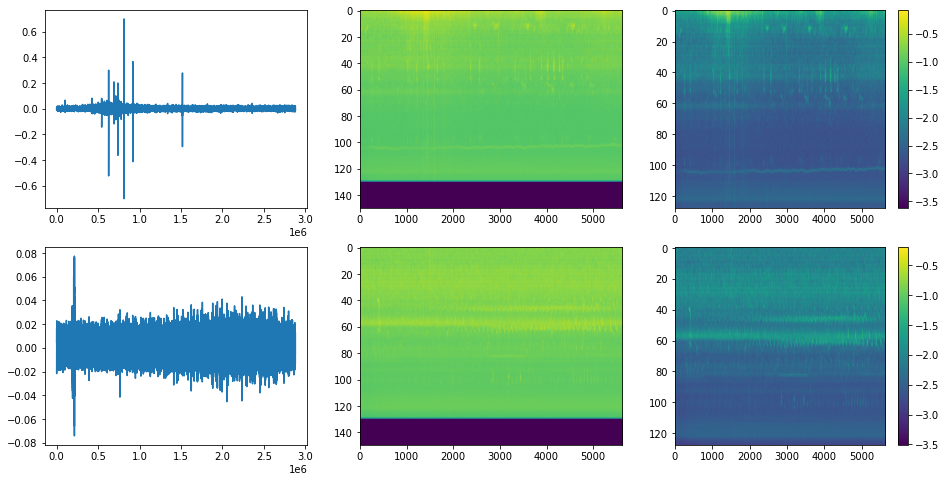

In [35]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 3, 1)
plt.plot(y)
plt.subplot(2, 3, 2)
plt.imshow(logmel.T, aspect="auto")
plt.subplot(2, 3, 3)
plt.imshow(logmel.T[:128, :], aspect="auto")
plt.colorbar()
y, sr = librosa.load(path=train_tp_list[100], sr=48000)
# y = (y -y.mean()) / y.std()
logmel = logmelfilterbank(
    y,
    sr,
    fft_size=2048,
    hop_size=512,
    win_length=None,
    window="hann",
    num_mels=150,
    fmin=50,
    fmax=48000,
    eps=1e-10,
)
plt.subplot(2, 3, 4)
plt.plot(y)
plt.subplot(2, 3, 5)
plt.imshow(logmel.T, aspect="auto")
plt.subplot(2, 3, 6)
plt.imshow(logmel.T[:128, :], aspect="auto")
plt.colorbar()
plt.savefig("spec.png")

In [40]:
(logmel.mean(axis=0) > -3).sum()

129

In [22]:
logmel.shape

(5626, 150)

In [45]:
train_tp_list[10].split("/")[-1][:-5]

'01b41f92b'